In [ ]:
import warnings
warnings.filterwarnings("ignore")

from scripts import utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, PowerTransformer, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import log_loss
import optuna
from tqdm import tqdm

from sklearn.ensemble import GradientBoostingClassifier

import pickle

# Read Dataset

In [3]:
train = pd.read_csv("../datasets/KDDTrain+.csv")
test = pd.read_csv("../datasets/KDDTest+.csv")
df = pd.concat([train, test], axis=0)

# Rename column
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'difficulty'
]

df.rename({f"Column{i+1}" : col for i,col in enumerate(columns)}, axis=1, inplace=True)

# Tipe fitur
categoric_features = [
    "protocol_type", "service", "flag", "land", "logged_in",
    "root_shell", "su_attempted", "is_host_login", "is_guest_login"
]
numeric_features = [
    'duration', 'src_bytes', 'dst_bytes','wrong_fragment', 'urgent',
    'hot', 'num_failed_logins', 'num_compromised', 'num_root',
    'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
]
to_drop_features = ['difficulty']

# Drop kolom yang tidak relevan
df.drop(columns=to_drop_features, inplace=True)

# Mapping tipe serangan ke kategori
attack_mapping = {
    # Normal Traffic
    'normal': 'normal',

    # Denial of Service (DoS)
    'neptune': 'DoS',         # SYN Flood
    'back': 'DoS',            # Back Orifice (flood)
    'teardrop': 'DoS',        # Fragmentation Attack
    'smurf': 'DoS',           # ICMP Flood
    'pod': 'DoS',             # Ping of Death
    'land': 'DoS',            # LAND Attack
    'apache2': 'DoS',         # Apache HTTP DoS
    'processtable': 'DoS',    # Process Table Exhaustion
    'mailbomb': 'DoS',        # Email Spam Flood
    'udpstorm': 'DoS',        # UDP Flood
    'ps': 'DoS',              # Process Spawn Attack
    'xlock': 'DoS',           # Xlock Resource Exhaustion

    # Remote to Local (R2L) - Unauthorized Access
    'guess_passwd': 'R2L',    # Password Brute Force
    'ftp_write': 'R2L',       # FTP Write Exploit
    'imap': 'R2L',            # IMAP Exploit
    'phf': 'R2L',             # PHF CGI Exploit
    'multihop': 'R2L',        # Multi-hop Compromise
    'warezclient': 'R2L',     # Warez Client Activity
    'warezmaster': 'R2L',     # Warez Server Exploit
    'spy': 'R2L',             # Spyware Activity
    'snmpguess': 'R2L',       # SNMP Brute Force
    'snmpgetattack': 'R2L',   # SNMP Get Exploit
    'sendmail': 'R2L',        # Sendmail Vulnerability
    'xsnoop': 'R2L',          # X Window Snooping
    'sqlattack': 'R2L',       # SQL Injection

    # User to Root (U2R) - Privilege Escalation
    'buffer_overflow': 'U2R', # Classic BoF Exploit
    'rootkit': 'U2R',         # Rootkit Installation
    'loadmodule': 'U2R',      # Kernel Module Hijacking
    'perl': 'U2R',            # Perl Script Exploit
    'xterm': 'U2R',           # Xterm Escape Exploit
    'named': 'U2R',           # BIND DNS Exploit (Privilege Escalation)
    'worm': 'DoS',            # Worm sebagai DoS (karena traffic overload)

    # Probing (Scanning/Surveillance)
    'ipsweep': 'Probing',     # Network Scanning
    'portsweep': 'Probing',   # Port Scanning
    'nmap': 'Probing',        # Nmap Scanning
    'satan': 'Probing',       # SATAN Vulnerability Scanner
    'mscan': 'Probing',       # Massive Scanning
    'saint': 'Probing',       # SAINT Exploit Scanner
    'httptunnel': 'Probing',  # HTTP Tunneling untuk C2/Scanning
}
df['label'] = df['label'].map(attack_mapping)

print(f"Ukuran dataset : {df.shape}")
df.head()

Ukuran dataset : (148517, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,DoS
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


# Exploratory Data Analysis

## 1. Drop Duplicated

In [4]:
print(f"Ukuran dataset awal: {df.shape}")
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

# Drop duplikasi data
df.drop_duplicates(keep='first', inplace=True)

print(f"\nUkuran dataset akhir: {df.shape}")
print(f"Jumlah data duplikat: {df.duplicated().sum()}")

Ukuran dataset awal: (148517, 42)
Jumlah data duplikat: 629

Ukuran dataset akhir: (147888, 42)
Jumlah data duplikat: 0


## 2. Cek Missing Value

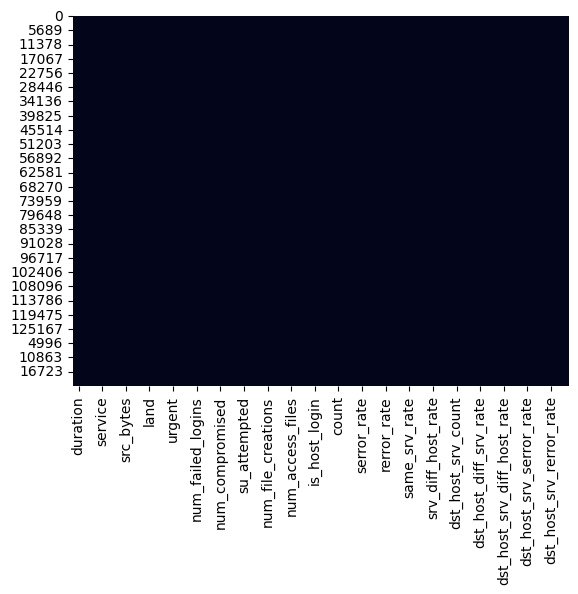

In [5]:
sns.heatmap(df.isnull(), cbar=False);

In [6]:
utils.cek_missing(df)

,Jumlah,Persentase
duration,0,0.0
protocol_type,0,0.0
service,0,0.0
flag,0,0.0
src_bytes,0,0.0
dst_bytes,0,0.0
land,0,0.0
wrong_fragment,0,0.0
urgent,0,0.0
hot,0,0.0


## 3. Cek Imbalance Dataset

In [7]:
print("Target proportion:")
df.label.value_counts(normalize=False)

Target proportion:


label
normal     76967
DoS        53011
Probing    14068
R2L         3723
U2R          119
Name: count, dtype: int64

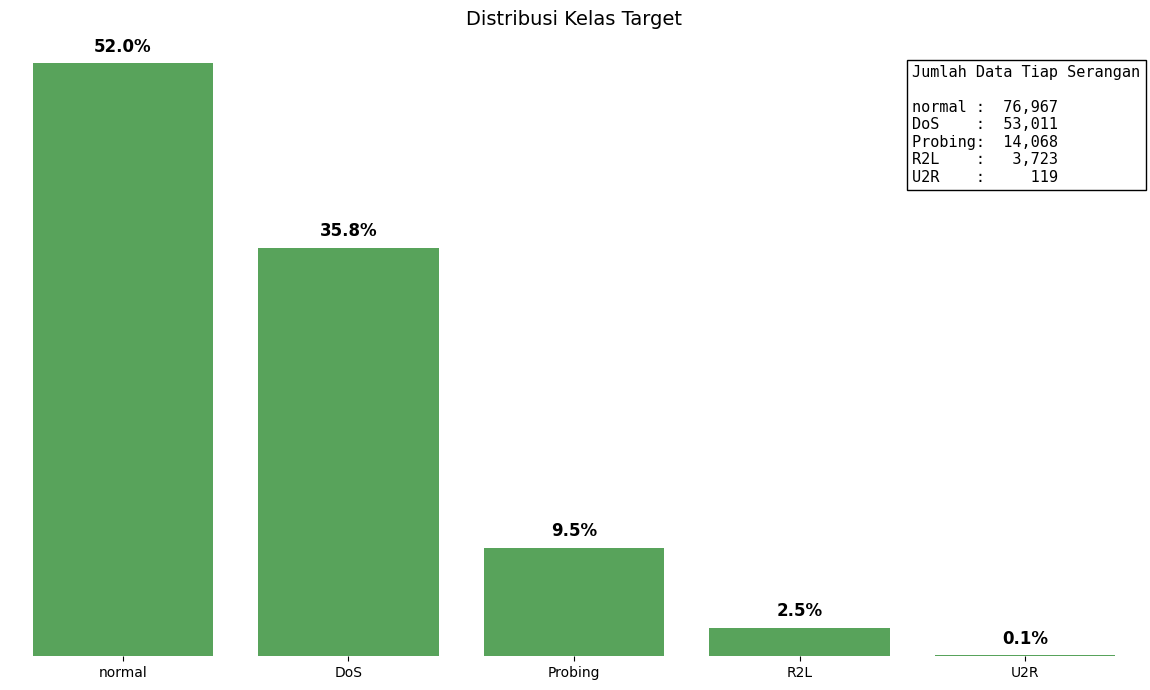

In [8]:
label_counts = df['label'].value_counts()
label_percent = (label_counts / label_counts.sum()) * 100

plt.figure(figsize=(12, 7))
bars = sns.barplot(x=label_counts.index, y=label_percent.values, color="#4CAF50")  # warna seragam

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{bar.get_height():.1f}%", ha='center', fontsize=12, weight='bold')

summary = "\n".join([f"{k:<7}: {v:>7,}" for k, v in label_counts.items()])
plt.text(x=3.5, y=max(label_percent)*0.8, s=f"Jumlah Data Tiap Serangan\n\n{summary}",
         bbox=dict(facecolor='white', edgecolor='black'), fontsize=11, family='monospace')

plt.gca().axes.get_yaxis().set_visible(False)
plt.box(False)
plt.title("Distribusi Kelas Target", fontsize=14)
plt.xlabel("")
sns.despine()
plt.tight_layout()
plt.show()

## 4. Distribusi Fitur Numerik

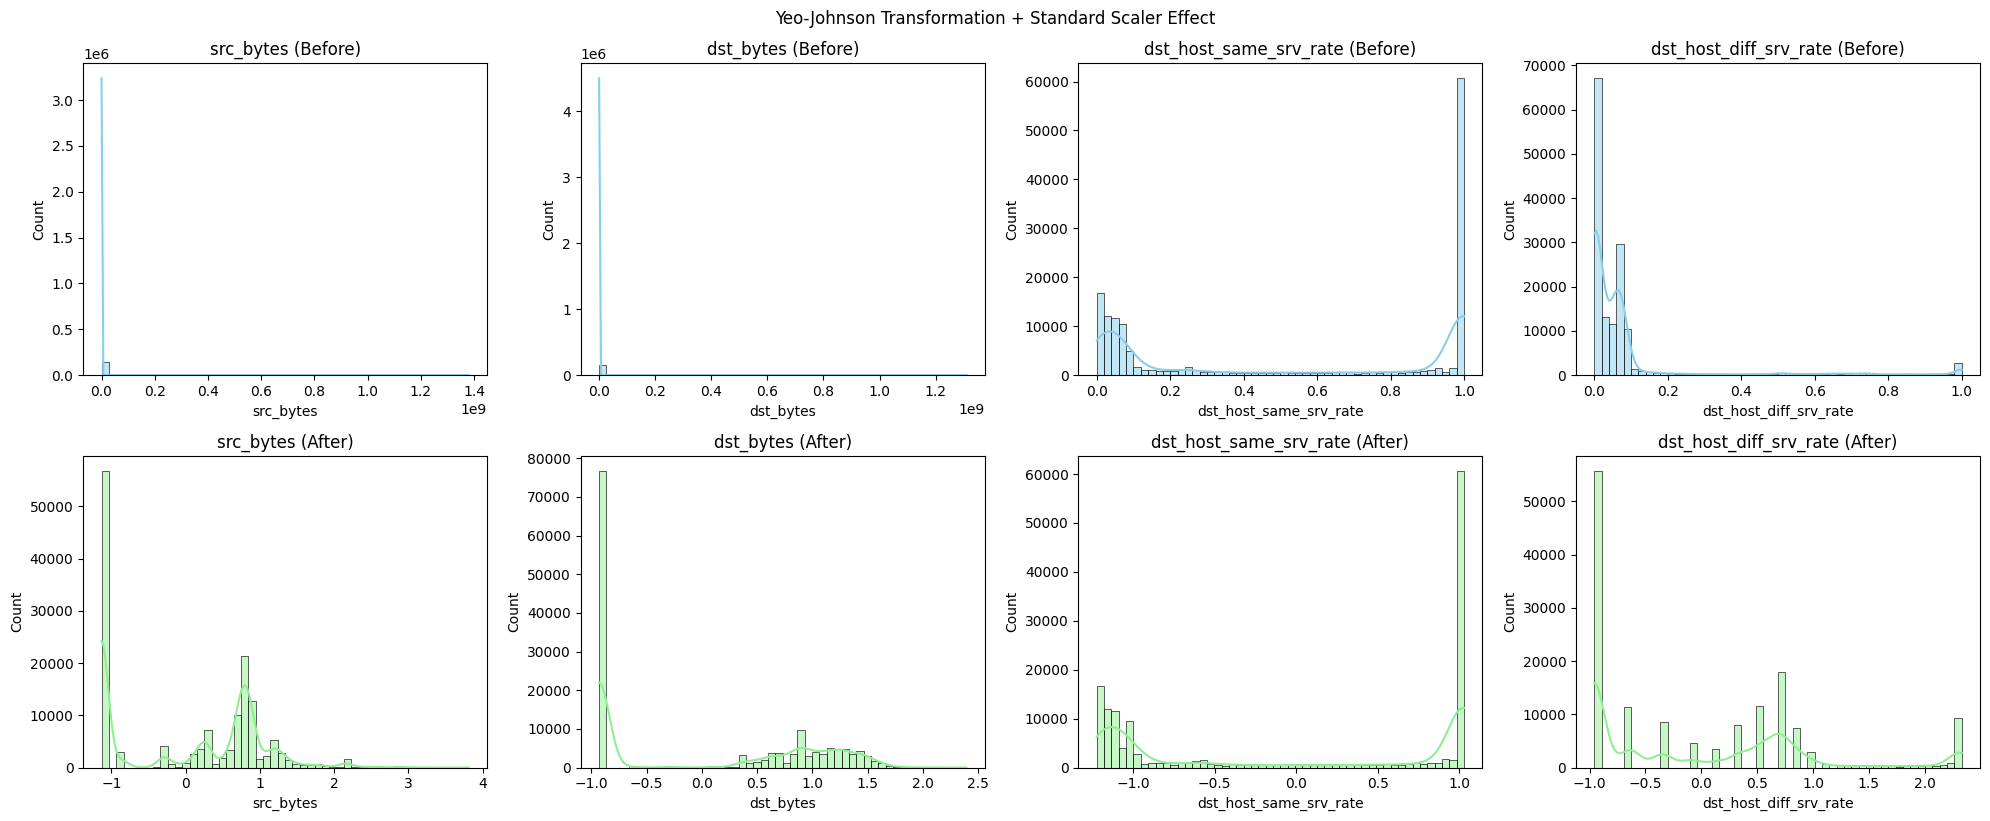

In [9]:
features = ['src_bytes', 'dst_bytes', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate']
df_selected = df[features]

# Yeo-Johnson + Standard Scaler
pt = PowerTransformer(method='yeo-johnson')
scaled = StandardScaler().fit_transform(pt.fit_transform(df_selected))
df_transformed = pd.DataFrame(scaled, columns=features)

# Plot Before & After
fig, axes = plt.subplots(2, len(features), figsize=(20, 8))
for i, col in enumerate(features):
    sns.histplot(df[col], kde=True, ax=axes[0, i], bins=50, color='skyblue')
    axes[0, i].set_title(f"{col} (Before)")
    
    sns.histplot(df_transformed[col], kde=True, ax=axes[1, i], bins=50, color='lightgreen')
    axes[1, i].set_title(f"{col} (After)")
    
plt.tight_layout()
plt.suptitle("Yeo-Johnson Transformation + Standard Scaler Effect", y=1.02)
plt.show()

## 5. Heatmap Correlation

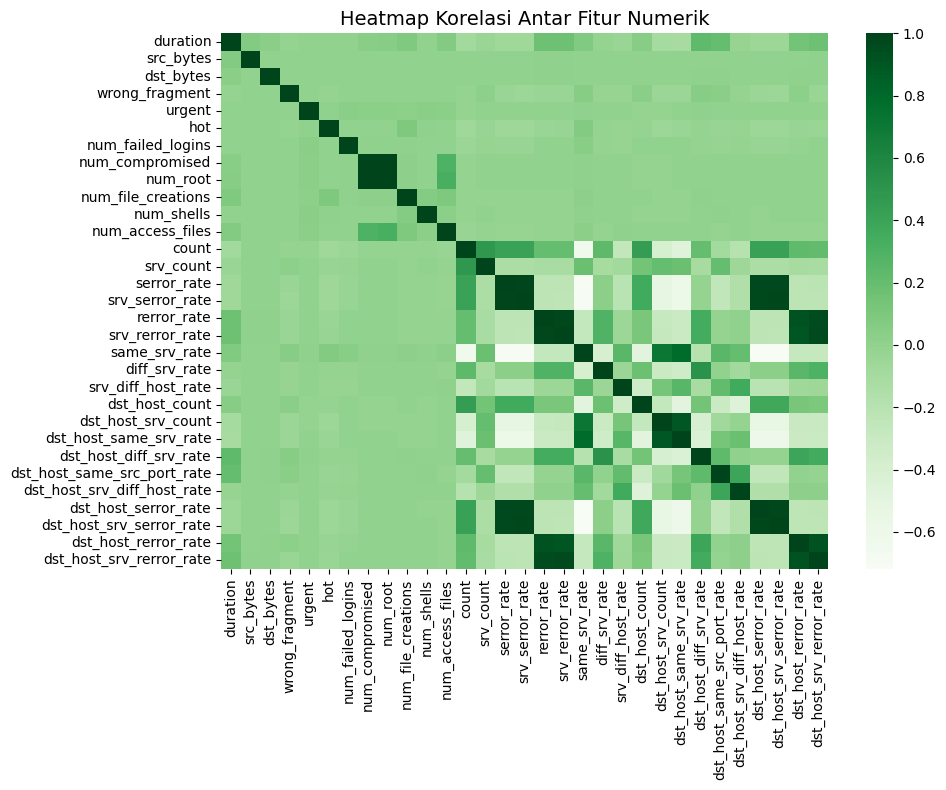

In [10]:
numeric_features_no_outbound = [col for col in numeric_features if col != 'num_outbound_cmds']
corr_matrix = df[numeric_features_no_outbound].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap="Greens", cbar=True)

plt.title("Heatmap Korelasi Antar Fitur Numerik", fontsize=14)
plt.tight_layout()
plt.show()

# Splitting Dataset

In [11]:
X = df.drop(columns=["label"])
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((118310, 41), (29578, 41), (118310,), (29578,))

# Feature Engineering & Data Preprocessing

In [12]:
categoric_pipeline = Pipeline([
    ('encoder',utils.TargetFeatureEncoder(to_encode=categoric_features))
])

numeric_pipeline = Pipeline([
    ('yeojohnson', utils.YeoJohnsonTransformer(columns=numeric_features)),
    ('scaler', utils.StandardScalerTransformer(columns=numeric_features))
])

preprocessor = ColumnTransformer([
    ('categoric', categoric_pipeline, categoric_features),
    ('numeric', numeric_pipeline, numeric_features)
], verbose_feature_names_out=False)

In [13]:
# Encode label menjadi angka
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_test_enc = label_encoder.transform(y_test)

In [14]:
# Compute sample weights untuk menangani ketidakseimbangan kelas
sample_weights = compute_sample_weight('balanced', y_train_enc)

# Feature Selection

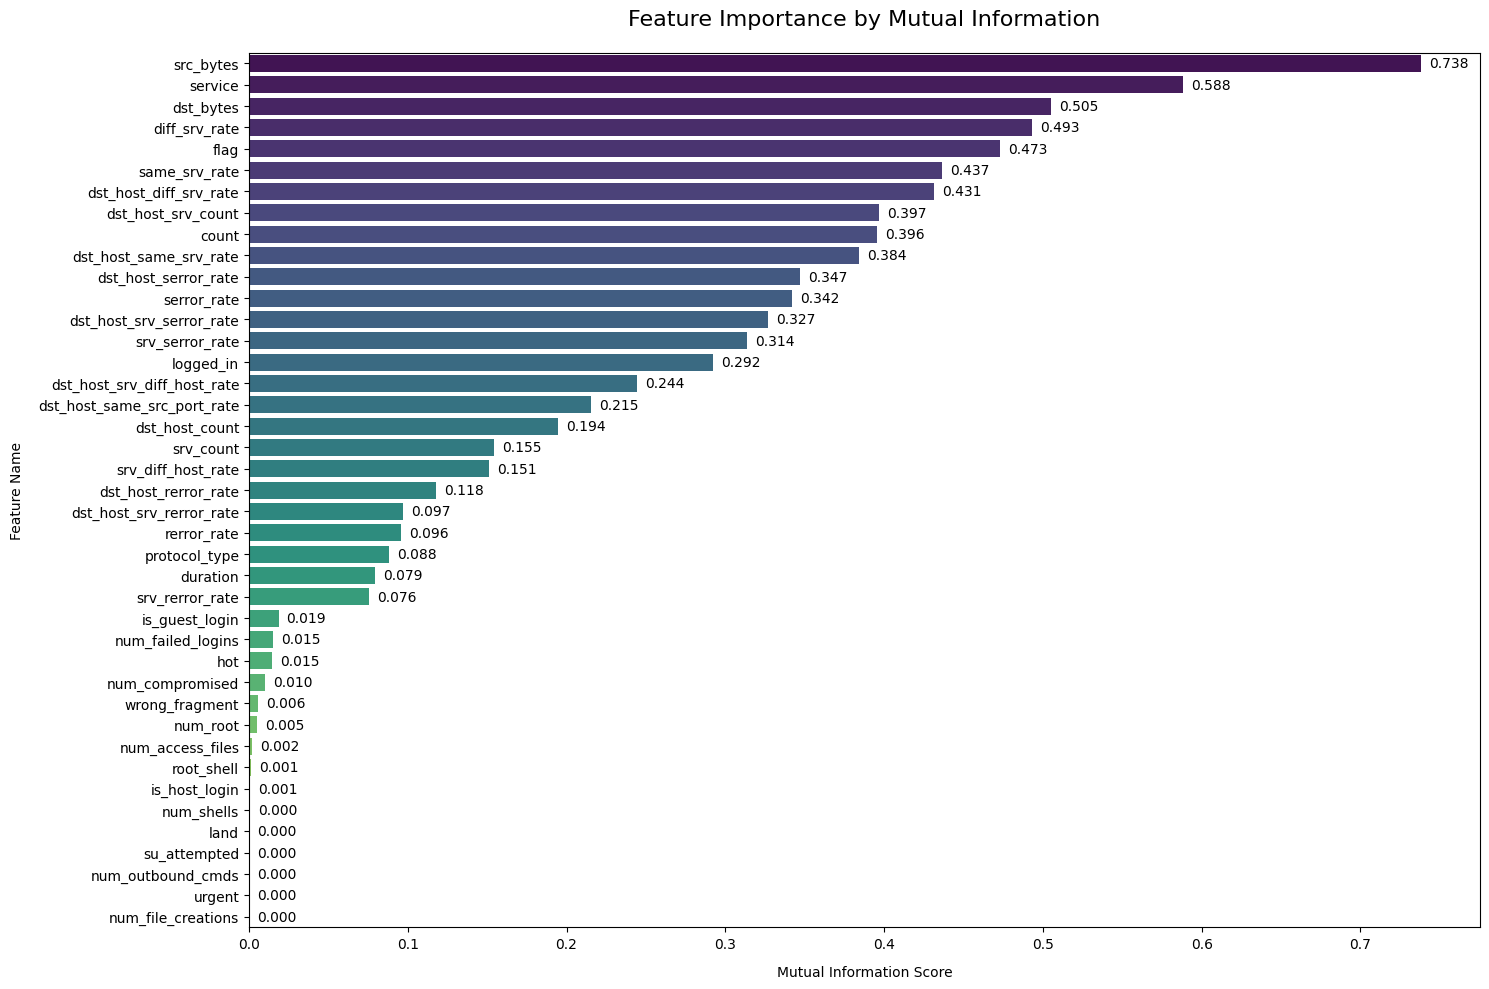

In [15]:
# Mutual Information
preprocessor.fit(X_train, y_train_enc)
mi_results = utils.plot_mutual_info_scores(preprocessor, X_train, y_train_enc)

# Model Training

In [16]:
# Konstanta
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26

# Inisialisasi model GBM biasa dengan semua hyperparameter (1 nilai per parameter)
gbm_model = GradientBoostingClassifier(
    loss='log_loss',
    random_state=42
)

# Feature selector
feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('algo', utils.StratifiedKFoldMulticlass(
        estimator=gbm_model,
        n_folds=3,
        method='predict_proba',
        random_state=42
    ))
])

# Fit model ke data training
pipeline.fit(
    X_train,
    y_train_enc,
    algo__sample_weight=sample_weights
)


,steps,"[('preprocessor', ...), ('feature_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categoric', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [17]:
# Prediction
y_pred_enc = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

Classification Report:
              precision    recall  f1-score   support

         DoS   0.998678  0.997359  0.998018     10602
     Probing   0.972879  0.994314  0.983480      2814
         R2L   0.699517  0.971812  0.813483       745
         U2R   0.162393  0.791667  0.269504        24
      normal   0.997460  0.969532  0.983298     15393

    accuracy                       0.981777     29578
   macro avg   0.766185  0.944937  0.809556     29578
weighted avg   0.987376  0.981777  0.983735     29578



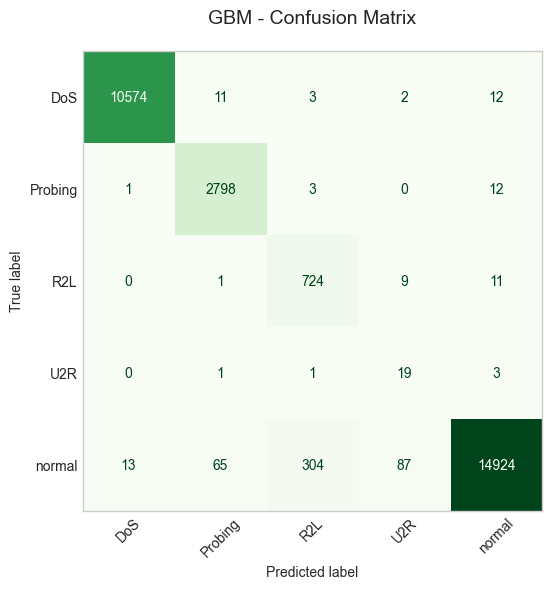


Weighted Average ROC-AUC: 0.999611


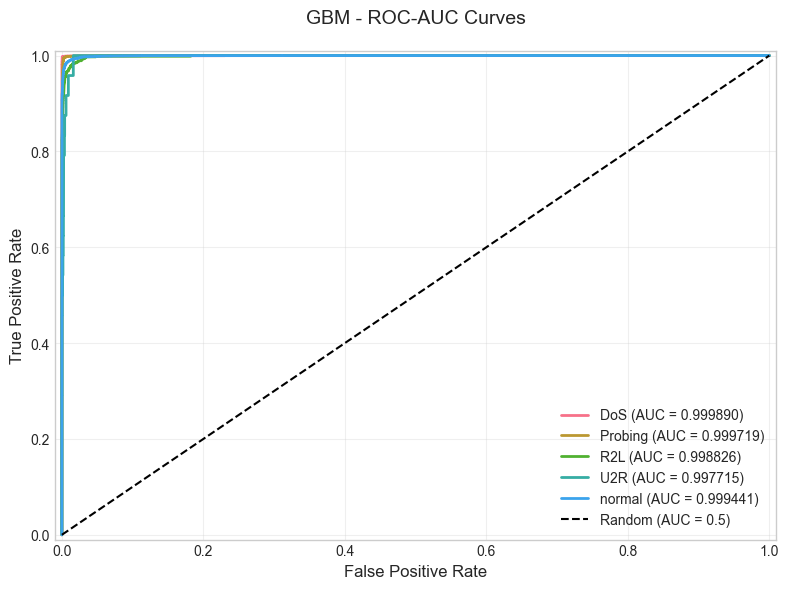

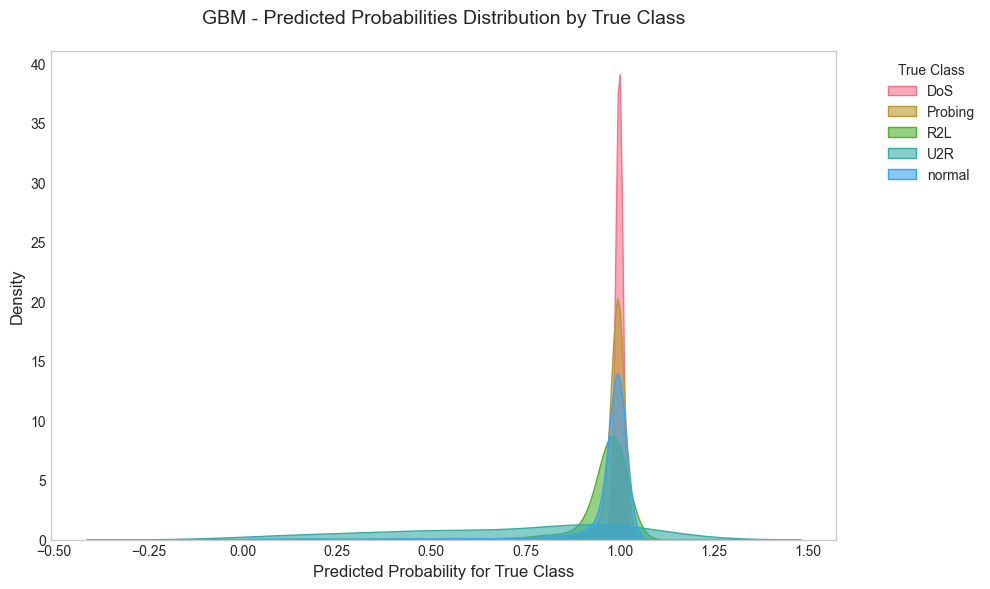

In [18]:
# Evaluation
evaluator = utils.ClassificationEvaluator(
    y_true=y_test_enc,
    y_pred=y_pred_enc,
    y_proba=y_proba,
    label_encoder=label_encoder
)

evaluator.plot_confusion_matrix(title="GBM - Confusion Matrix")
evaluator.plot_roc_curves(title="GBM - ROC-AUC Curves")
evaluator.plot_probability_distribution(title="GBM - Predicted Probabilities Distribution by True Class")

# Hyperparameter Tuning

In [29]:
# Konstanta
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26
N_TRIALS = 10

# Feature selector
feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

# Objective function untuk Optuna
def manual_objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'learning_rate': trial.suggest_float('learning_rate', 0.03, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': 4,
        'min_samples_leaf': 3,
        'subsample': 0.8,
        'max_features':'sqrt',
        'loss': 'log_loss',
        'random_state': 42
    }

    model = GradientBoostingClassifier(**params)

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('clf', model)
    ])

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    losses = []

    for train_idx, valid_idx in skf.split(X_train, y_train_enc):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train_enc[train_idx], y_train_enc[valid_idx]
        sw_tr = sample_weights[train_idx]

        pipeline.fit(X_tr, y_tr, clf__sample_weight=sw_tr)
        y_pred_proba = pipeline.predict_proba(X_val)
        losses.append(log_loss(y_val, y_pred_proba))

    return np.mean(losses)

# Jalankan tuning
study = optuna.create_study(direction='minimize')
for _ in tqdm(range(N_TRIALS), desc="Optuna Trials"):
    study.optimize(manual_objective, n_trials=1, catch=(Exception,))


[I 2025-07-02 20:30:13,915] A new study created in memory with name: no-name-a7042413-88de-44bd-b812-680f18b10e86
Optuna Trials: 100%|██████████| 10/10 [1:03:39<00:00, 381.98s/it]


In [31]:
print("Best trial:")
print("  Value (log loss):", study.best_value)
print("  Params:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (log loss): 0.015421428661657972
  Params:
    n_estimators: 609
    learning_rate: 0.058636566929651385
    max_depth: 5


# Evaluation

In [32]:
# Konstanta
NUM_CLASSES = len(label_encoder.classes_)
TOP_K = 26

# Ambil hyperparameter terbaik dari hasil tuning Optuna
best_params = {
    'n_estimators': study.best_trial.params['n_estimators'],
    'max_depth': study.best_trial.params['max_depth'],
    'learning_rate': study.best_trial.params['learning_rate'],
    'subsample': study.best_trial.params.get('subsample', 1.0),  # default jika tidak dituning
    'min_samples_split': study.best_trial.params.get('min_samples_split', 2),
    'min_samples_leaf': study.best_trial.params.get('min_samples_leaf', 1),
    'max_features': study.best_trial.params.get('max_features', 'sqrt'),
    'loss': 'log_loss',
    'random_state': 42
}

# Inisialisasi model GBM dengan best params
gbm_model = GradientBoostingClassifier(**best_params)

# Feature selector
feature_selector = SelectKBest(score_func=mutual_info_classif, k=TOP_K)

# Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', feature_selector),
    ('algo', utils.StratifiedKFoldMulticlass(
        estimator=gbm_model,
        n_folds=3,
        method='predict_proba',
        random_state=42
    ))
])

# Fit model ke data training
pipeline.fit(
    X_train,
    y_train_enc,
    algo__sample_weight=sample_weights
)


,steps,"[('preprocessor', ...), ('feature_selector', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('categoric', ...), ('numeric', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [33]:
# Prediction
y_pred_enc = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

Classification Report:
              precision    recall  f1-score   support

         DoS   0.999245  0.998868  0.999057     10602
     Probing   0.993980  0.997512  0.995743      2814
         R2L   0.933248  0.975839  0.954068       745
         U2R   0.550000  0.458333  0.500000        24
      normal   0.997070  0.994738  0.995902     15393

    accuracy                       0.995571     29578
   macro avg   0.894709  0.885058  0.888954     29578
weighted avg   0.995585  0.995571  0.995562     29578



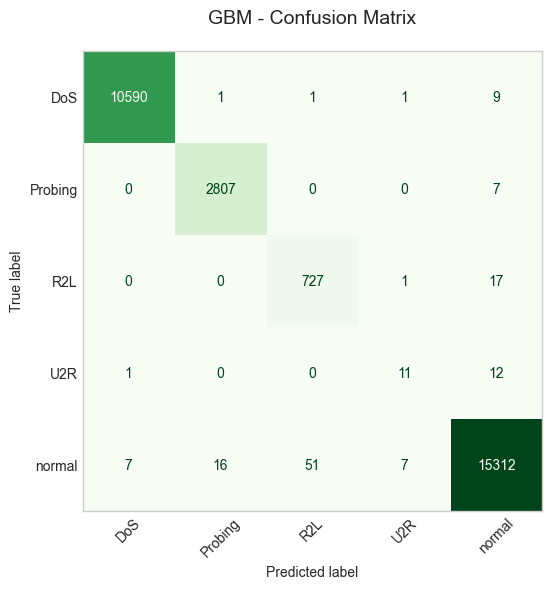


Weighted Average ROC-AUC: 0.999961


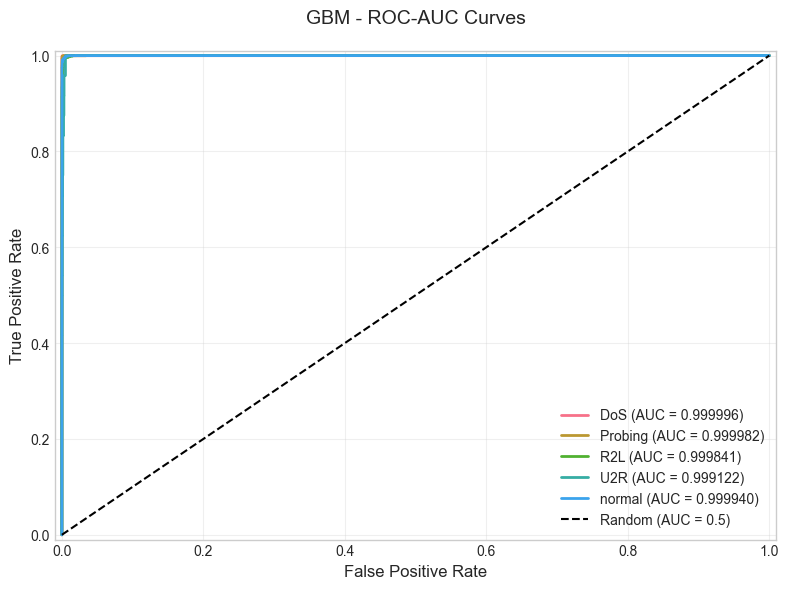

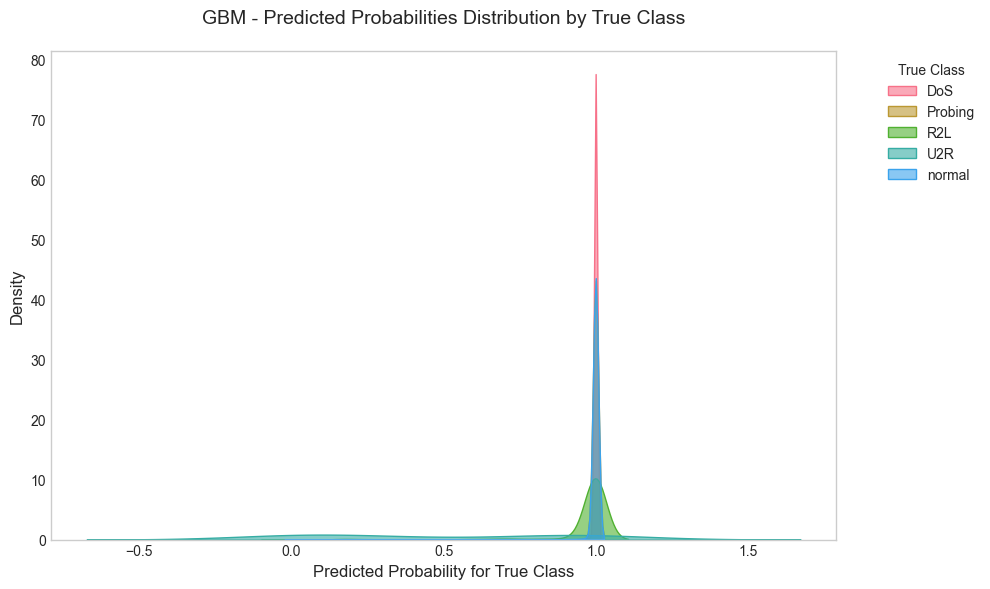

In [34]:
# Evaluation
evaluator = utils.ClassificationEvaluator(
    y_true=y_test_enc,
    y_pred=y_pred_enc,
    y_proba=y_proba,
    label_encoder=label_encoder
)

evaluator.plot_confusion_matrix(title="GBM - Confusion Matrix")
evaluator.plot_roc_curves(title="GBM - ROC-AUC Curves")
evaluator.plot_probability_distribution(title="GBM - Predicted Probabilities Distribution by True Class")

# Save Model

In [35]:
# Simpan pipeline dan model ke file menggunakan pickle
with open("../models/gbm_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

with open("../models/gbm_model.pkl", "wb") as f:
    pickle.dump(gbm_model, f)